In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

for i in [np, pd, mpl, sns, sklearn]:
    print(i.__name__, i.__version__)

numpy 1.18.5
pandas 0.25.1
matplotlib 3.5.3
seaborn 0.12.2
sklearn 0.21.3


# 4-5 앙상블 모델(Ensemble Model)


머신 러닝 문제에 대해 모델 하나만으로 좋은 성능을 내도록 하는 것은 무척 어렵습니다.

여러 개의 모델을 결합하여 더 좋은 모델을 만드는 기법이 앙상블입니다.

**앙상블 이론**

앙상블 모델 구성의 다양성이 클 경우 좋은 성능을 보이는 경향이 있습니다.

→ 앙상블 모델은 앙상블을 구성하는 모델 간의 다양성을 고려하는 방향으로 발전해 왔습니다.

### Abalone

[Abalone](https://archive.ics.uci.edu/dataset/1/abalone) 데이터셋: 전복의 생육 정보 데이터입니다.


|Name|Data Type|	Meas.|	Description|
|----|---------|-----|-----------|
|Sex|nominal||M, F, and I (infant)|
|Length|continuous|mm|Longest shell measurement|
|Diameter|continuous|mm|perpendicular to length|
|Height|continuous|mm|with meat in shell|
|Whole|continuous|grams|whole abalone|
|Shucked|continuous|grams|weight of meat|
|Viscera|continuous|grams|gut weight (after bleeding)|
|Shell|continuous|grams|after being dried|
|Rings|integer||+1.5 gives the age in years|

In [2]:
df_abalone = pd.read_csv('data/abalone.csv')
df_abalone.head()

,Sex,Length,Diameter,Height,Whole,Shucked,Viscera,Shell,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## 배깅(Bagging)

배깅(Bagging)은 부트스트랩(Bootstrap) + 집계(Aggregation) 합성어 입니다.

### 부트스트랩(Bootstrap)

- 주어진 데이터에서 표본을 중복을 포함하여(with replacement) 뽑아 내는 표본 추출 방법으로 복원 추출이라고도 불립니다.


- 부트스트랩(Bootstrap)은 사이즈가 충분하고, 주어진 데이터 수만큼 표본을 추출했을 때, 전체 데이터셋에서 1/e (37.8%)의 데이터는 부트스트랩한 데이터에는 포함되지 않습니다.


- 여러 개의 표본 집합을 부트스트랩(Bootstrap)과 비복원 추출을 비교 한다면, 복원 추출을 통해서 만들 표본 집합 간의 다양성이 비복원 추출보다 다양합니다.

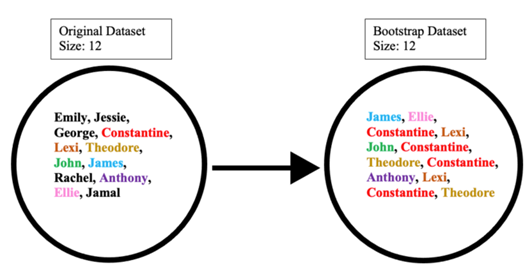

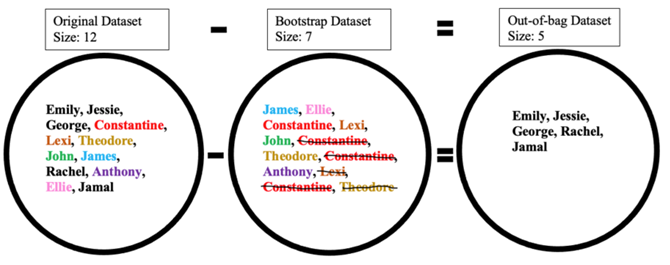

이미지 출처: https://en.wikipedia.org/wiki/Bootstrap_aggregating

부트스트랩(Bootstrap)을 통해 추출한 표본 집합들로 만들어진 모델들은 표본 집합들의 다양성으로 인해 다양한 결과를 내게되어 **앙상블 이론**에 따라 

더 좋은 결과를 보이게 될 가능성이 높아집니다

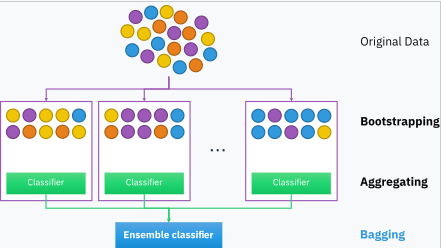

이미지 출처: https://en.wikipedia.org/wiki/Bootstrap_aggregating


#### OOB(Out-Of-Bag) 표본

부트스트랩(Bootstrap)에서 선택되지 않은 표본입니다.

- 학습에 사용이 되지 않았기 때문에, 기반 모델의 일반화 성능을 측정하는 목적으로 사용됩니다.


### 집계(Aggregation)

- 주로 여러 모델의 결과를 주로 평균을 내어 집계를 내어 출력을 만듭니다.

> $F_T(x) = \frac{1}{n}\sum_{t=1}^T f_t(x)$, $f_t$: t번 모델의 입력 (x)에 대한 출력 함수

- 집계(Aggregation) 연산은 순서성이 없으므로 학습 / 예측 과정의 **병렬화**가 가능합니다.


- 표본의 크기가 커질 수록 표본 평균의 분산이 줄어드는 것처럼, 앙상블 구성 모델의 수가 커질 수록, 모델의 분산은 줄어 드는 경향이 있습니다. 

>  이러한 양상은 K-최근접 이웃 모델에서도 보입니다. 예측을 낼 때의 근접 이웃의 수 K를 늘릴 수록 모델의 분산이 줄고 편향이 커지는 것과 일맥상통합니다.

**[Ex.1]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_abalone을 80%는 학습데이터 df_train, 20%는 평가데이터 df_test로 나눕니다. 

Rings를 예측하는 Bagging Regressor를 만듭니다.

입력 변수는 Age를 제외한 모든 변수를 사용하고, 성별(Sex)는 가변수화 합니다.

베이스 모델을 DecisionTreeRegressor로 합니다. 

Bagging 모델의 수에 따라 분산을 측정하고 성능을 측정합니다. (1~100개)

df_train 모델로 학습을 하고, 분산을 측정합니다. df_test 모델로는 성능을 측정합니다. 

성능 측정 지표는 평균제곱오차(MSE, Mean Squared Error)를 사용합니다.

sklearn에서 제공하는 모듈을 사용하여 보일 수 있지만 작동 원리를 보이기 위해 Bagging과 Aggregation은 직접 구현합니다.
    
</div>

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
df_train, df_test = train_test_split(
    pd.get_dummies(df_abalone, columns=['Sex']), 
    train_size=0.8, random_state=123
)
X_cols = [i for i in df_train.columns if i != 'Rings']

In [4]:
# Bootstrap 만을 해봅니다.

df_bootstrap = df_train.sample(frac=1.0, replace=True, random_state=123) # replace=True로 하면 복원 추출 방식으로 표본을 뽑습니다.
df_bootstrap.index.nunique() / len(df_train) # ≒ 복원 추출을 통해 1 - 1/e 의 Case 만 뽑힙니다.

0.6357378030529781

In [5]:
from sklearn.tree import DecisionTreeRegressor

df_oob_prds = []
models  = []
n_estimators_range = np.arange(1, 101)
for i in n_estimators_range:
    df_bootstrap = df_train.sample(frac=1.0, replace=True) # Bootstrap
    df_oob = df_train.loc[~df_train.index.isin(df_bootstrap.index.unique())]
    reg_dt  = DecisionTreeRegressor()
    reg_dt.fit(df_bootstrap[X_cols], df_bootstrap['Rings'])
    models.append(reg_dt)
    
    df_oob_prds.append(
        pd.Series(reg_dt.predict(df_oob[X_cols]), index=df_oob.index, name=i)
    )

In [6]:
df_train_prds = pd.concat([
    pd.Series(model.predict(df_train[X_cols]), index=df_train.index, name=i) 
    for i, model in enumerate(models)
], axis=1)
df_test_prds = pd.concat([
    pd.Series(model.predict(df_test[X_cols]), index=df_test.index, name=i) 
    for i, model in enumerate(models)
], axis=1)
df_oob_prds = pd.concat(df_oob_prds, axis=1)

In [7]:
s_train_prd_var = [df_train_prds.iloc[:, :i].mean(axis=1).var() for i in range(1, 101)]
s_test_mse = [mean_squared_error(df_test['Rings'], df_test_prds.iloc[:, :i].mean(axis=1)) for i in range(1, 101)]

In [8]:
# OOB에 포함되지 않았던 표본의 개수를 확인합니다.
df_oob_prds.isna().all(axis=1).sum()

0

In [9]:
s_oob_mse = mean_squared_error(df_train['Rings'], df_oob_prds.mean(axis=1))
s_oob_mse

16.740411054084113

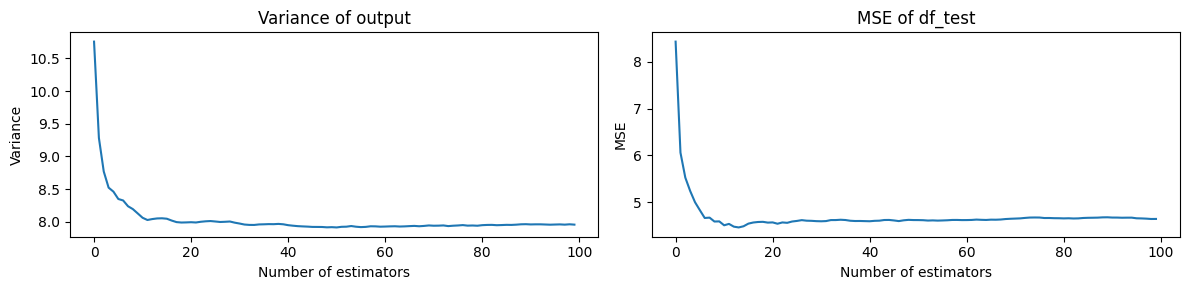

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(s_train_prd_var)
axes[0].set_title('Variance of output')
axes[0].set_xlabel('Number of estimators')
axes[0].set_ylabel('Variance')
axes[1].plot(s_test_mse)
axes[1].set_title('MSE of df_test')
axes[1].set_xlabel('Number of estimators')
axes[1].set_ylabel('MSE')
plt.tight_layout()
plt.show()

**sklearn.ensemble.BaggingClassifier**, **sklearn.ensemble.BaggingRegressor**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|base_estimator|기반 모델|
|n_estimators|기반 모델 수 |
|bootstrap|Bootstrap 여부|
|max_samples|하나의 모델 학습 시 사용할 표본 비율|
|max_features|하나의 모델 학습 시 사용할 입력 변수(속성) 비율|

**[Ex.2]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

Ex.1에서 n_estimators 수와 max_leaf_nodes를 아래 리스트의 조합으로 설정하여 df_train의 분산, df_train과 df_test의 성능을 측정합니다.

n_estimators가 클수록 모델의 분산은 작아지고, max_leaf_nodes가 클수록 모델의 편향은 줄고 분산은 커집니다.

Bagging 모델에서 Base 모델의 편향과 분산에 따른 경향을 살펴봅니다.

```python
n_estimators_list = [1, 3, 5, 10, 25, 50]
max_leaf_nodes_list = [4, 8, 16, 32, 64, 96, 128, 160, 192, 256, 384, 512]
```
    
</div>

In [11]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

mse_train, mse_test = dict(), dict()
prd_train_var = dict()
n_estimators_list = [1, 3, 5, 10, 25, 50]
max_leaf_nodes_list = [4, 8, 16, 32, 64, 96, 128, 160, 192, 256, 384, 512]
for j in n_estimators_list:
    mse_train[j], mse_test[j], prd_train_var[j] = list(), list(), list()
    for i in max_leaf_nodes_list:
        reg_bagg = BaggingRegressor(
            DecisionTreeRegressor(max_leaf_nodes=i),
            n_estimators=j,
            random_state=123
        )

        reg_bagg.fit(df_train[X_cols], df_train['Rings'])
        prd_train = reg_bagg.predict(df_train[X_cols])
        prd_train_var[j].append(prd_train.var())
        mse_train[j].append(mean_squared_error(df_train['Rings'], prd_train))
        mse_test[j].append(mean_squared_error(df_test['Rings'], reg_bagg.predict(df_test[X_cols])))

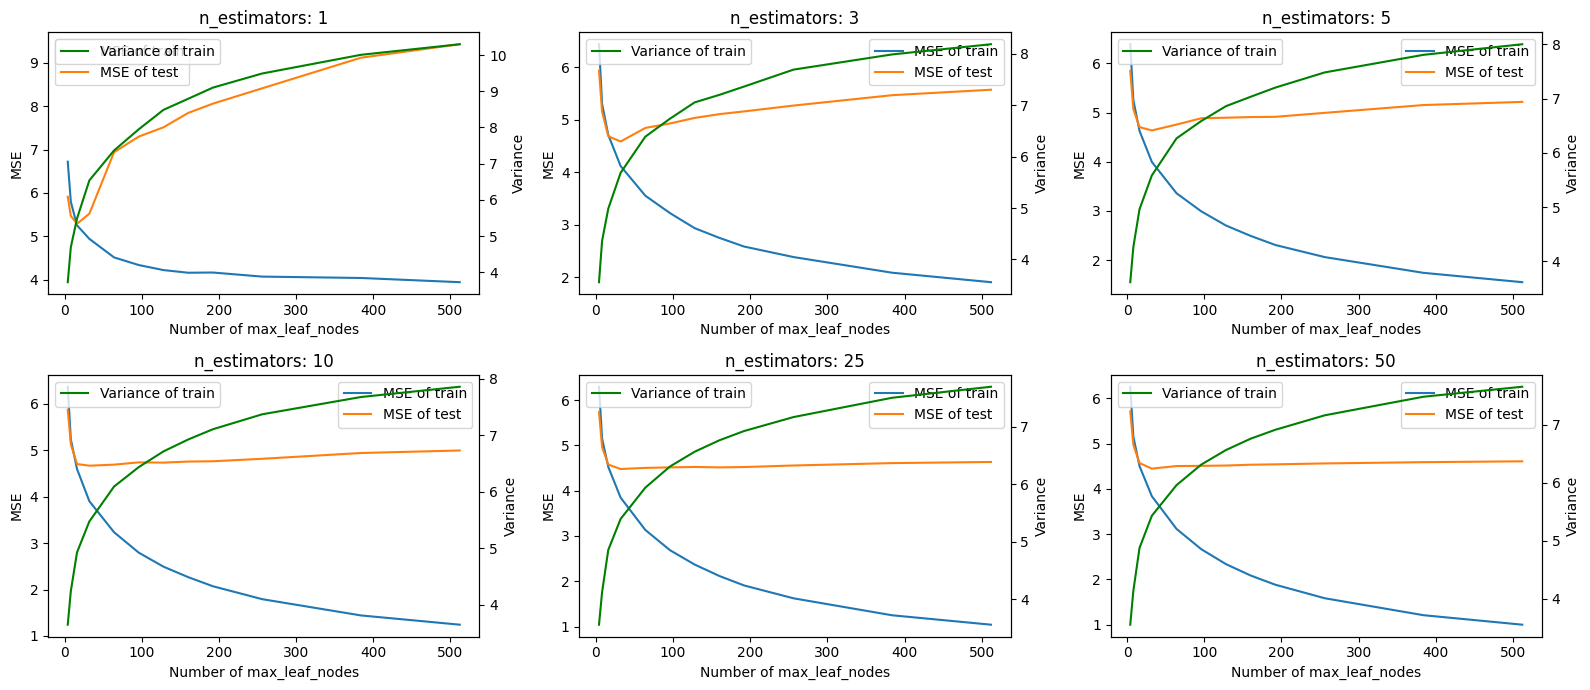

In [12]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
for i, ax in zip(n_estimators_list, axes.ravel()):
    ax.plot(max_leaf_nodes_list, mse_train[i], label='MSE of train')
    ax.plot(max_leaf_nodes_list, mse_test[i], label='MSE of test')
    ax.set_xlabel('Number of max_leaf_nodes')
    ax.set_ylabel('MSE')
    tax = ax.twinx()
    tax.plot(max_leaf_nodes_list, prd_train_var[i], color='green', label='Variance of train')
    tax.set_ylabel('Variance')
    ax.legend()
    tax.legend()
    ax.set_title('n_estimators: {}'.format(i))
plt.tight_layout()
plt.show()

### 랜덤포레스트(RandomForest)

배깅 + 의사 결정 나무 입니다.

**sklearn.ensemble.RandomForestClassifier**, **sklearn.ensemble.RandomForestRegressor**

**주요 하이퍼파라메터**

DecisionTree와 Bagging 모델의 하이퍼파라메터를 모두 사용합니다.

**[Ex.3]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

[Ex.2]를 sklearn.ensemble.RandomForestClassifier로 구현해봅니다.
    
</div>

In [13]:
from sklearn.ensemble import RandomForestRegressor

mse_train, mse_test = dict(), dict()
prd_train_var = dict()
n_estimators_list = [1, 3, 5, 10, 25, 50]
max_leaf_nodes_list = [4, 8, 16, 32, 64, 96, 128, 160, 192, 256, 384, 512]
for j in n_estimators_list:
    mse_train[j], mse_test[j], prd_train_var[j] = list(), list(), list()
    for i in max_leaf_nodes_list:
        reg_rf = RandomForestRegressor(
            max_leaf_nodes=i,
            n_estimators=j,
            random_state=123
        )

        reg_rf.fit(df_train[X_cols], df_train['Rings'])
        prd_train = reg_rf.predict(df_train[X_cols])
        prd_train_var[j].append(prd_train.var())
        mse_train[j].append(mean_squared_error(df_train['Rings'], prd_train))
        mse_test[j].append(mean_squared_error(df_test['Rings'], reg_rf.predict(df_test[X_cols])))

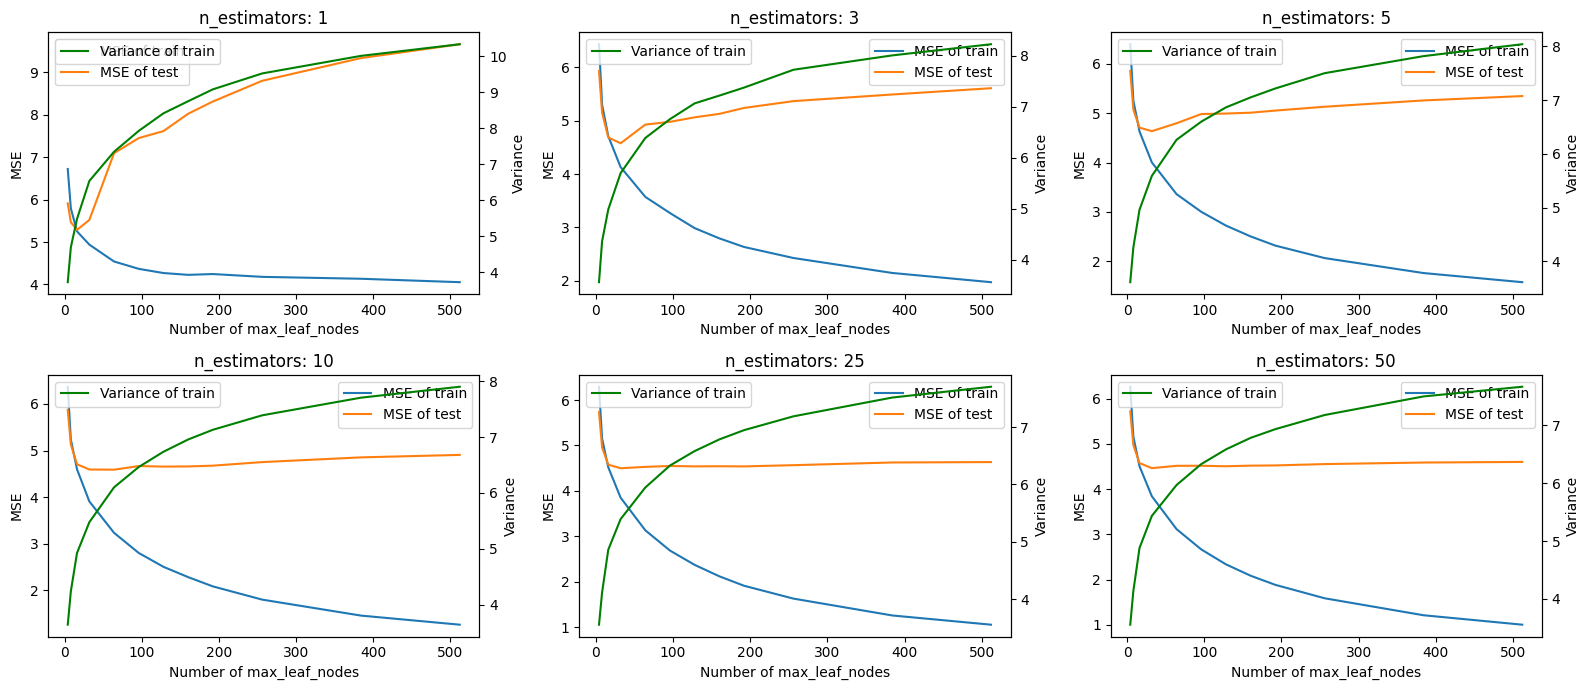

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
for i, ax in zip(n_estimators_list, axes.ravel()):
    ax.plot(max_leaf_nodes_list, mse_train[i], label='MSE of train')
    ax.plot(max_leaf_nodes_list, mse_test[i], label='MSE of test')
    ax.set_xlabel('Number of max_leaf_nodes')
    ax.set_ylabel('MSE')
    tax = ax.twinx()
    tax.plot(max_leaf_nodes_list, prd_train_var[i], color='green', label='Variance of train')
    tax.set_ylabel('Variance')
    ax.legend()
    tax.legend()
    ax.set_title('n_estimators: {}'.format(i))
plt.tight_layout()
plt.show()

## 부스팅(Boosting)

앙상블 모델을 수식으로 정리해 봅니다. 

> $F_M(x) = \sum_{m=1}^Mf_m(x)$
>
> $f_m(x) = \alpha_th_m(x)$, $h_m(x)$: m번 모델의 출력 함수, $h_m$ m번째 모델, $\alpha_m$ 모델의 가중치


앙상블 모델의 학습는 손실을 최소로 하는 $F_M(x)$를 찾는 것입니다.

이를 수식으로 표현하면,

> $F_M(x) = argmin_FE_{x,y}[L(y, F(x))]$ 입니다. $L$: 손실 함수

하지만 최적의 $F_M(x)$ 한 번에 도출하는 것은 무척 풀기 어려운 문제입니다. 

$F_M(x)$ 를 순차적인 과정을 통해 최적의 $F_M(x)$를 단계적으로 구성한 앙상블 모델이 바로 Boosting입니다.


이를 수식으로 표현하면,

> $F_m(x) = F_{m-1}(x) + \left(argmin_{\alpha_m, h_m}[\sum_{i=1}^nL(y_i, F_{m-1}(x_i) + \alpha_mh_m(x_i))]\right)(x)$


-  $h_m(x)$는 주로 약한 학습기(Weak learner)를 사용합니다.

> Weak Learner: 주로 약한 성능을 지닌, 즉 편향이 높거나 분산이 낮은 모델입니다.


- 부스팅(Boosting) 기법은 기반 모델을 **순차적**으로 결합하여 점진적으로 예측 성능을 향상을 시킵니다.

> 점차적으로 모델의 편향이 낮아지고, 분산이 커집니다.


### AdaBoost(Adaptive Boosting)

$F_{m-1}(x)$ 모델의 각 학습 데이터 별 손실을 측정하여, 손실에 비례하여 학습 데이터에 가중치를 부여합니다.

$h_m(x)$ 모델을 데이터의 가중치에 따라 학습합니다.

$h_m(x)$을 $F_{m-1}(x)$과 더하여 $F_{m}(x)$을 만들 때의 $\alpha_m$은 $F_{m}(x)$의 손실이 최소가 되는 값을 취합니다. 

> $\alpha_m = argmin_{\alpha} \sum_{i=1}^N L(y_i, F_{m-1} + \alpha h_m(x)) $

#### 학습 알고리즘


1. 학습 데이터 가중치 $w_i, i= 1,...,n$ 을 $1/n$으로 초기화 합니다. m = 1로 초기화합니다. ($n$: 학습 데이터수)


2. 기반 모델 $h_m$을 학습 데이터을 가중치 w를 사용하여 학습을 시킵니다.


3. $F_{m}(x)$ 의 손실을 최소화하는 $\alpha_m$을 구합니다.

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px; margin-left:15px">

**[Ex]** 이진 분류 모델

모든 i,j에 대해 $h_j(x_i) \in \{-1, 1\}$ 이고, $y_i \in \{-1, 1\}$

$F_{m-1}(x_i) = \alpha_1h_1(x_i) + ... \alpha_{m-1}h_{m-1}(x_i)$

$F_{m}(x_i) = F_{m-1}(x_i) + \alpha_mh_m(x_i)$ 

데이터의 가중치에 따라 모델 $h_m(x)$를 학습하고, 최적의 $\alpha_i$를 구합니다.

여기에서는 Exponential loss 를 사용해봅니다.

>  Exponential loss = $e^{-y_iF_{m}(x_i)}$, $y_i \in {-1, 1}, -\infty \le F_{m}(x_i) \le \infty$

Exponential loss는 계산이 간단합니다. 분류 오차가 클수록 손실이 현저하게 커지는 특징이 있습니다.

$E = \sum_{i=1}^N e^{-y_iF_m(x_i)} = \sum_{i=1}^N e^{-y_iF_{m-1}(x_i)}e^{-y_i\alpha_mh_m(x_i)}$

오차 $E$를 최소화하는 $\alpha_m$을 구합니다.

m 단계에서 i번째 표본의 가중치를 $w_i^{(m)}$로 정의합니다 

> $w_i^{(m)} = e^{-y_iF_{m-1}(x_i)}$

표본 가중치 $w_i^{(m)}$에 따라 $h_m(x_i)$를 학습합니다.

> $E = \sum_{i=1}^N w_i^{(m)}e^{-y_i\alpha_mh_m(x_i)}$

여기서, $h_m(x_i)$가 맞을 경우는, $y_ih_m(x_i) = 1$, 틀릴 경우는 $y_ih_m(x_i) = -1$ 이 됩니다. 이에 따라 $E$를 정리하면,

> $E = \sum_{y_i=h_m(x_i)} w_i^{(m)}e^{-\alpha_m} + \sum_{y_i \ne h_m(x_i)} w_i^{(m)}e^{\alpha_m}$

$\frac{\partial{E}}{\partial{\alpha_m}} = 0$ 일 때, $E$의 값이 최소가 됩니다.

이를 풀어 정리하면, 

$\alpha_m = \frac{1}{2}ln\left(\frac{\sum_{y_i=h_m(x_i)} w_i^{(m)}}{\sum_{y_i \ne h_m(x_i)} w_i^{(m)}}\right)$

이를 가중 오차율 (weighted error rate)로 나타냅니다.

$\epsilon_m = \sum_{y_i \ne h_m(x_i)} w_i^{(m)} / \sum_{i=1}^N w_i^{(m)}$ 

$\alpha_m = \frac{1}{2}ln\left(\frac{1 - \epsilon_m}{\epsilon_m}\right)$
    
</div>

4. $F_{m}(x_i) = F_{m-1}(x_i) + \alpha_mh_m(x_i)$  으로 병합 시킵니다.


5. $w$를 $F_{m}(x)$의 손실로 업데이트 합니다.


6. $\sum_{i=1}^n{w_i} = 1$이 되도록 정규화 합니다. 


7. m = m + 1, 종료 조건을 만족하지 않으면 2단계로 이동합니다.

**[Ex.4]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

기반 모델을 의사 결정 나무(sklearn.tree.DecisionTreeClassifier, min_samples_leaf=8, random_state=123)인 

AdaBoost 모델을 직접 만들어 학습시킵니다.

이 과정을 통해서 AdaBoost 모델의 학습 과정을 파악과 함께 특성을 알아 봅니다.

df_abalone에서 성별(Sex)가 I이면 -1, M 또는 F이면 1로 하는 변수 Class를 만듭니다.

df_abalone을 80%는 학습데이터 df_train, 20%는 평가데이터 df_test로 나눕니다. 

모델이 추가 될 때마다, 모델의 분산과 df_train, df_test의 성능을 측정해 봅니다. 

성능 측정 지표는 AUC(Area under of receiver operating charateristic Curve) 입니다.
    
</div>

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
df_abalone['Class'] = np.where(df_abalone['Sex'] == 'I', -1, 1)

df_train, df_test = train_test_split(df_abalone, train_size=0.8, random_state=123)
X_cols = [i for i in df_train.columns if i != 'Class' and i != 'Sex']
np.array(X_cols)

array(['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera',
       'Shell', 'Rings'], dtype='<U8')

In [62]:
n = len(df_train)
X, y = df_train[X_cols], df_train['Class']
n_estimators = 100
w_sam = np.ones(n) / n # w를 초기화 합니다.
alphas = list() # alpha를 저장합니다.
models = list() # 모델을 저장합니다.
F_m = np.zeros(n) # 초기의 출력입니다. F_m(x_i) ≥ 0 →1, F_m(x_i) < 0 →-1

for i in range(n_estimators):
    clf_dt = DecisionTreeClassifier(min_samples_leaf=8, random_state=123)
    clf_dt.fit(X, y, sample_weight=w_sam) # 기반 모델을 w_sam을 가중치로 하여 학습합니다.
    models.append(clf_dt)
    h_m = clf_dt.predict(X)
    e_m = (w_sam * (h_m != y)).sum()
    alpha = 0.5 * (np.log(1 - e_m) - np.log(e_m)) # 기반 모델의 가중치를 구합니다.
    alphas.append(alpha)

    F_m = F_m + alpha * h_m # 출력을 업데이트 합니다.
    w_sam = np.exp(-F_m * y.values) # 출력으로 w를 업데이트 합니다.
    w_sam = w_sam / w_sam.sum()

In [63]:
df_train_prds = pd.concat(
    [pd.Series(model.predict(X), index=df_train.index, name=i) for i, model in enumerate(models)], axis=1
) # 모델 별로 학습 데이터의 예측 결과를 뽑습니다.

df_test_prds = pd.concat(
    [pd.Series(model.predict(df_test[X_cols]), index=df_test.index, name=i) for i, model in enumerate(models)], axis=1
) # 모델 별로 학습 데이터의 예측 결과를 뽑습니다.

df_train_prds.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2746,-1,-1,-1,1,-1,-1,1,-1,1,-1,...,1,1,-1,-1,1,-1,-1,-1,1,-1
853,1,1,1,1,1,1,1,1,1,1,...,-1,1,1,1,-1,1,1,1,1,1
1809,1,1,1,-1,1,1,1,1,-1,-1,...,1,1,-1,-1,-1,1,1,1,1,1
3419,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,-1,1,1,-1,1
1199,1,1,1,1,1,1,1,-1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [64]:
df_train_Fm = (df_train_prds * alphas).cumsum(axis=1) # 가중치를 곱한 후 라운드별 출력값을 cumsum을 이용하여 만듭니다.
df_test_Fm = (df_test_prds * alphas).cumsum(axis=1)

In [65]:
auc_train = [roc_auc_score(y, df_train_Fm[i]) for i in range(n_estimators)] # 라운드별 AUC를 측정합니다.
auc_test = [roc_auc_score(df_test['Class'], df_test_Fm[i]) for i in range(n_estimators)]

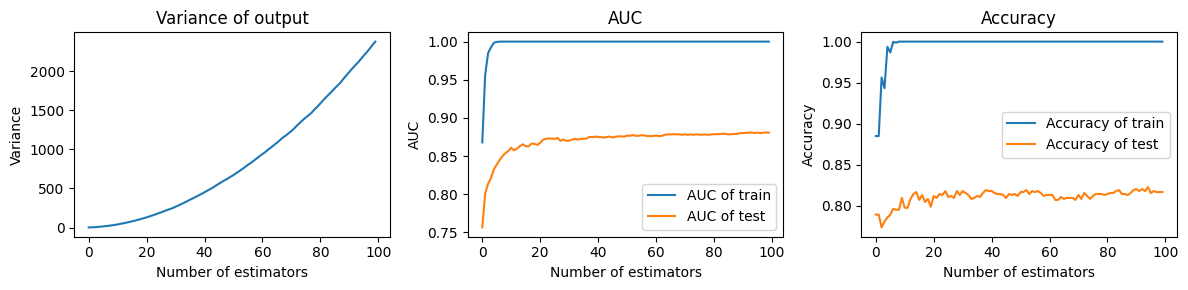

In [73]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
axes[0].plot(df_train_Fm.var())
axes[0].set_title('Variance of output')
axes[0].set_xlabel('Number of estimators')
axes[0].set_ylabel('Variance')
axes[1].plot(auc_train, label='AUC of train')
axes[1].plot(auc_test, label='AUC of test')
axes[1].set_title('AUC')
axes[1].set_xlabel('Number of estimators')
axes[1].set_ylabel('AUC')
axes[1].legend()
# Accuracy 추가 요청
axes[2].plot((((df_train_Fm > 0) * 2 - 1) == y.to_frame().values).mean(), label='Accuracy of train')
axes[2].plot((((df_test_Fm > 0) * 2 - 1) == df_test[['Class']].values).mean(), label='Accuracy of test')
axes[2].set_title('Accuracy')
axes[2].set_xlabel('Number of estimators')
axes[2].set_ylabel('Accuracy')
axes[2].legend()
plt.tight_layout()
plt.show()

**sklearn.ensemble.AdaBoostClassifier**, **sklearn.ensemble.AdaBoostRegressor**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|base_estimator|기반 모델|
|n_estimators|기반 모델 수|
|learning_rate|학습율|

**[Ex.5]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

Ex.4에서 n_estimators 수와 max_leaf_nodes를 아래 리스트의 조합으로 설정하여 df_train의 분산, df_train과 df_test의 성능을 측정합니다.

n_estimators가 클수록 모델의 분산은 작아지고, max_leaf_nodes가 클수록 모델의 편향은 줄고 분산은 커집니다.

AdaBoost 모델에서 Base 모델의 편향과 분산에 따른 경향을 살펴봅니다.

```python
n_estimators_list = [1, 3, 5, 10, 25, 50]
max_leaf_nodes_list = [4, 8, 16, 32, 64, 96, 128, 160, 192, 256, 384, 512]
```
    
</div>

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

roc_train, roc_test = dict(), dict()
prd_train_var = dict()
n_estimators_list = [1, 3, 5, 10, 25, 50]
max_leaf_nodes_list = [4, 8, 16, 32, 64, 96, 128, 160, 192, 256, 384, 512]
for j in n_estimators_list:
    roc_train[j], roc_test[j], prd_train_var[j] = list(), list(), list()
    for i in max_leaf_nodes_list:
        clf_ab = AdaBoostClassifier(
            DecisionTreeClassifier(max_leaf_nodes=i),
            n_estimators=j,
            random_state=123
        )

        clf_ab.fit(df_train[X_cols], df_train['Class'])
        prd_train = clf_ab.decision_function(df_train[X_cols])
        prd_train_var[j].append(prd_train.var())
        roc_train[j].append(roc_auc_score(df_train['Class'], prd_train))
        roc_test[j].append(roc_auc_score(df_test['Class'], clf_ab.decision_function(df_test[X_cols])))

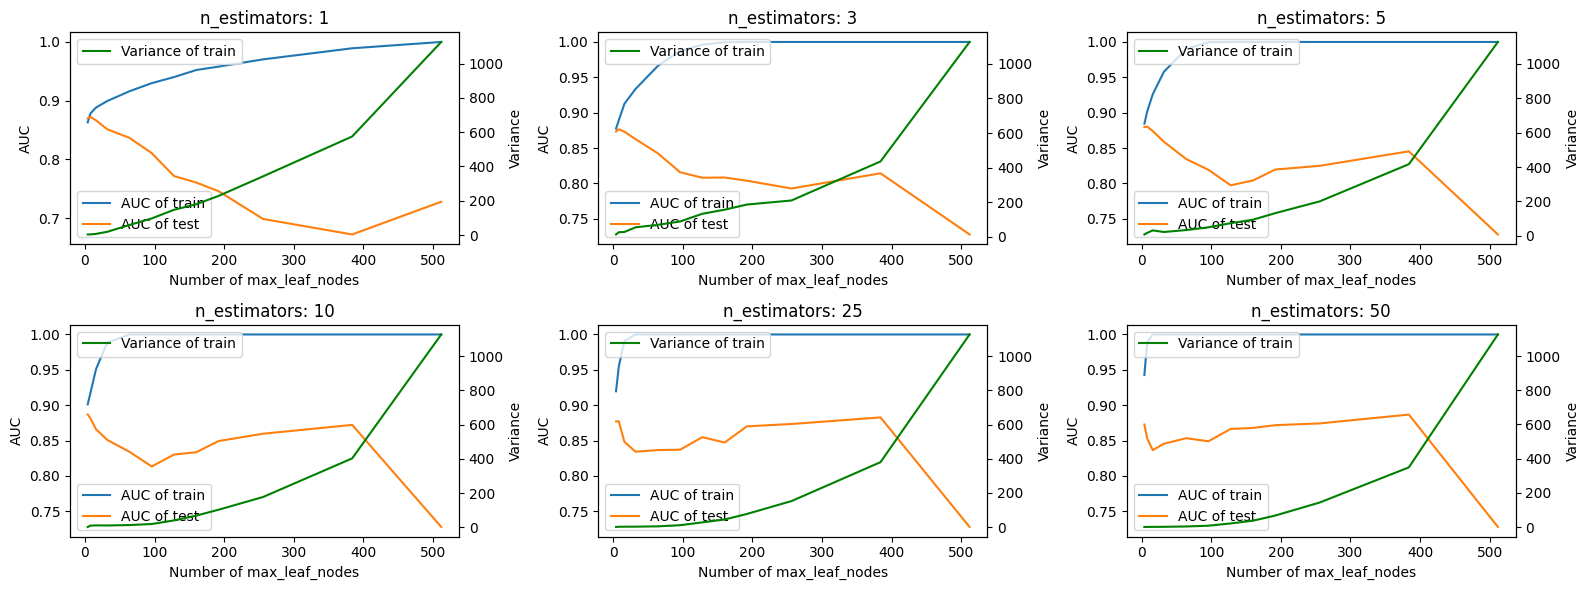

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
for i, ax in zip(n_estimators_list, axes.ravel()):
    ax.plot(max_leaf_nodes_list, roc_train[i], label='AUC of train')
    ax.plot(max_leaf_nodes_list, roc_test[i], label='AUC of test')
    ax.set_xlabel('Number of max_leaf_nodes')
    ax.set_ylabel('AUC')
    tax = ax.twinx()
    tax.plot(max_leaf_nodes_list, prd_train_var[i], color='green', label='Variance of train')
    tax.set_ylabel('Variance')
    ax.legend()
    tax.legend()
    ax.set_title('n_estimators: {}'.format(i))
plt.tight_layout()
plt.show()

### Gradient boosting

$F_m(x) = F_{m-1}(x) + \left(argmin_{\alpha_m, h_m}[\sum_{i=1}^nL(y_i, F_{m-1}(x_i) + \alpha_mh_m(x_i))]\right)(x)$ 에서,

$L(y_i, F_{m-1}(x))$에 대한 $F_{m-1}$의 기울기를 구하고,

경사하강법처럼 기울기 차감하면 보다 손실이는 줄어드는 것에 착안합니다.

> $F_m(x) = F_{m-1}(x) - \alpha_m\sum_{i=1}^n \nabla_{F_{m-1}}L(y_i, F_{m-1}(x_i))$

$h_m(x_i)$와 $\alpha_i$를 구하는 문제를 

$h_m(x_i)$가 기울기 $-\sum_{i=1}^n \nabla_{F_{m-1}}L(y_i, F_{m-1}(x_i))$ 학습하고,

손실의 차감을 최대화하는 $\alpha_m$를 찾는 것으로 바꿉니다.

이러한 앙상블 방법을 Gradient boosting이라고 합니다.

#### 학습 알고리즘

1. $F_0(x) = argmin_{const} \sum_{i=1}^n L(y_i, const)$, m = 1


2. $r_m = -\sum_{i=1}^n \nabla_{F_{m-1}}L(y_i, F_{m-1}(x_i))$ 기울기를 구합니다. 

> $\nabla_{F_{m-1}}L(y_i, F_{m-1}(x_i)) = \left[ -\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} \right]_{F(x_i)=F_{m-1}(x_i)}$

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px; margin-left:15px">
    
**[Ex] $L(y_i, \hat{y_i}) = \frac{1}{2}(y_i - \hat{y_i})^2$, 회귀 모델**

$\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)} = -(y_i - F(x_i))$
    
</div>

3. $r_m$을 대상 변수로 하고, $h_m(x)$를  학습 시킵니다.


4. $\alpha_m = argmin_\alpha \sum_{i=1}^n L(y_i, F_{m-1}(x_i) + \alpha h_m(x_i))$ 

> 보통 linear search를 사용합니다.

5. $F_{m}(x_i) = F_{m-1}(x_i) + \alpha_mh_m(x_i)$ 으로 병합시킵니다.


6. 종료 조건을 만족하지 않으면 2단계로 이동합니다.

**좀 더 직관적으로 표현하자면, 손실에 대한 출력값의 경사도를 맞추는 회귀 모델을 결합하는 과정입니다.**

**[Ex.6]** 

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

df_abalone을 80%는 학습데이터 df_train, 20%는 평가데이터 df_test로 나눕니다. 

Rings를 예측하는 Gradient boosting Regressor를 만듭니다.

입력 변수는 Age를 제외한 모든 변수를 사용하고, 성별(Sex)는 가변수화 합니다.

베이스 모델을 DecisionTreeRegressor(max_leaf_nodes=8)로 합니다. 

DecisionTreeRegressor 모델의 수에 따라 분산을 측정하고 성능을 측정합니다. (1~100개)

df_train 모델로 학습을 하고, 분산을 측정합니다. df_test 모델로는 성능을 측정합니다. 

성능 측정 지표는 평균제곱오차(MSE, Mean Squared Error)를 사용합니다.

sklearn에서 제공하는 모듈을 사용하여 보일 수 있지만 작동 원리를 보이기 위해 Gradient Descent Regressor 직접 구현합니다.
    
</div>

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
df_train, df_test = train_test_split(
    pd.get_dummies(df_abalone, columns=['Sex']), 
    train_size=0.8, random_state=123
)
X_cols = [i for i in df_train.columns if i != 'Rings']

In [24]:
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor

n = len(df_train)
X, y = df_train[X_cols], df_train['Rings']
n_estimators = 100
w_sam = np.ones(n) / n # w를 초기화 합니다.
alphas = list() # alpha를 저장합니다.
models = list() # 모델을 저장합니다.

reg_dum = DummyRegressor() # 가장 간단한 회귀모델로, 대상 변수의 평균으로 예측합니다.
reg_dum.fit(X, y)
models.append(reg_dum)
F_m = reg_dum.predict(X)
alphas.append(1)
search_alpha_list = np.arange(1, 101) / 100
learning_rate = 0.1
for i in range(n_estimators):
    r = y - F_m
    reg_dt = DecisionTreeRegressor(max_leaf_nodes=8, random_state=123)
    reg_dt.fit(X, r)
    prd = reg_dt.predict(X)
    alpha_min_idx = np.argmin([np.square(y - (F_m + prd * i)).mean() for i in search_alpha_list])
    alpha_m = search_alpha_list[alpha_min_idx] * learning_rate
    F_m = F_m + alpha_m * prd
    alphas.append(alpha_m)
    models.append(reg_dt)
alphas = np.array(alphas)

In [25]:
df_train_prds = pd.concat(
    [pd.Series(model.predict(X), index=df_train.index, name=i) for i, model in enumerate(models)], axis=1
) * alphas # 모델 별로 예측을 뽑고 가중치를 곱합니다.

df_test_prds = pd.concat(
    [pd.Series(model.predict(df_test[X_cols]), index=df_test.index, name=i) for i, model in enumerate(models)], axis=1
) * alphas # 모델 별로 예측을 뽑고 가중치를 곱합니다.

In [26]:
df_train_Fm = df_train_prds.cumsum(axis=1) # 라운드별 출력값을 cumsum을 이용하여 만듭니다.
df_test_Fm = df_test_prds.cumsum(axis=1)

In [27]:
mse_train = [mean_squared_error(y, df_train_Fm[i]) for i in range(n_estimators)] # 라운드별 AUC를 측정합니다.
mse_test = [mean_squared_error(df_test['Rings'], df_test_Fm[i]) for i in range(n_estimators)]

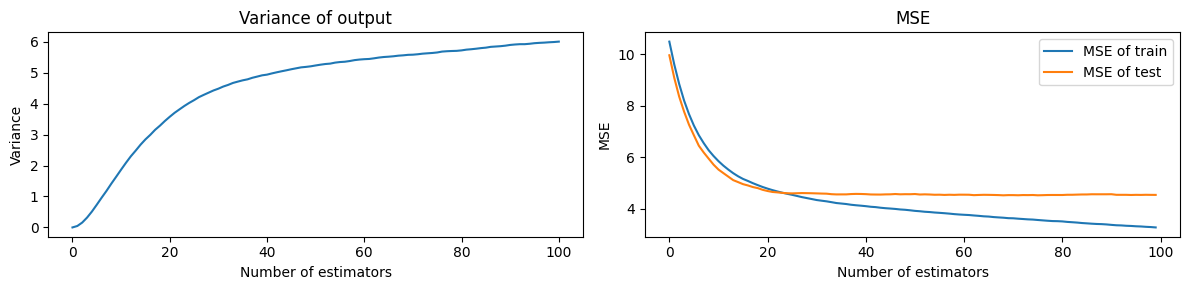

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(df_train_Fm.var())
axes[0].set_title('Variance of output')
axes[0].set_xlabel('Number of estimators')
axes[0].set_ylabel('Variance')
axes[1].plot(mse_train, label='MSE of train')
axes[1].plot(mse_test, label='MSE of test')
axes[1].set_title('MSE')
axes[1].set_xlabel('Number of estimators')
axes[1].set_ylabel('MSE')
axes[1].legend()
plt.tight_layout()
plt.show()

#### Bagging과 Boosting 구성 모델의 특징

Bagging은 구성하는 모델 예측 성능을 지니고 있고, 서로가 비슷한 성능을 보입니다.


Boosting을 구성하는 모델은 첫 번째 모델을 제외하고는 단독으로는 거의 예측 성능을 낼 수 없습니다.

In [29]:
(
    mean_squared_error(y, df_train_prds.iloc[:, 0]),
    mean_squared_error(y, df_train_prds.iloc[:, 1]), 
    mean_squared_error(y, df_train_prds.iloc[:, 2])
)

(10.498779236967783, 108.38811220006448, 108.44797066126351)

**sklearn.ensemble.GradientBoostingClassifier**, **sklearn.ensemble.GradientBoostingRegressor**

sklearn의 Gradient boosting 모델은 Decision Tree Regressor를 기반 모델로 합니다.

> 분류에서도 $r_m$이 $[-\infty, \infty]$입니다. 따라서 분류 문제에서 기반 모델이 회귀 모델이 되는 것입니다.

Decision Tree Regressor의 하이퍼 파라메터 대부분 설정이 가능합니다.

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|n_estimators|의사 결정 나무  수|
|learning_rate|학습율|
|max_samples|하나의 모델 학습 시 사용할 표본 비율|
|max_features|하나의 모델 학습 시 사용할 입력 변수(속성) 비율|

**[Ex.7]** 

Ex.5에서 n_estimators 수와 max_leaf_nodes를 아래 리스트의 조합으로 설정하여 df_train의 분산, df_train과 df_test의 성능을 측정합니다.

n_estimators가 클수록 모델의 분산은 작아지고, max_leaf_nodes가 클수록 모델의 편향은 줄고 분산은 커집니다.

Gradient boosting 모델에서 Base 모델의 편향과 분산에 따른 경향을 살펴봅니다.

```python
n_estimators_list = [5, 25, 50, 100, 150, 200]
max_leaf_nodes_list = [4, 8, 16, 32]
```

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

mse_train, mse_test = dict(), dict()
prd_train_var = dict()
n_estimators_list = [25, 50, 100, 200, 300, 500]
max_leaf_nodes_list = [4,  6, 8, 10, 13, 16]
for j in n_estimators_list:
    mse_train[j], mse_test[j], prd_train_var[j] = list(), list(), list()
    for i in max_leaf_nodes_list:
        reg_gb = GradientBoostingRegressor(
            max_leaf_nodes=i,
            n_estimators=j,
            random_state=123,
            learning_rate = 1e-2
        )

        reg_gb.fit(df_train[X_cols], df_train['Rings'])
        prd_train = reg_gb.predict(df_train[X_cols])
        prd_train_var[j].append(prd_train.var())
        mse_train[j].append(mean_squared_error(df_train['Rings'], prd_train))
        mse_test[j].append(mean_squared_error(df_test['Rings'], reg_gb.predict(df_test[X_cols])))

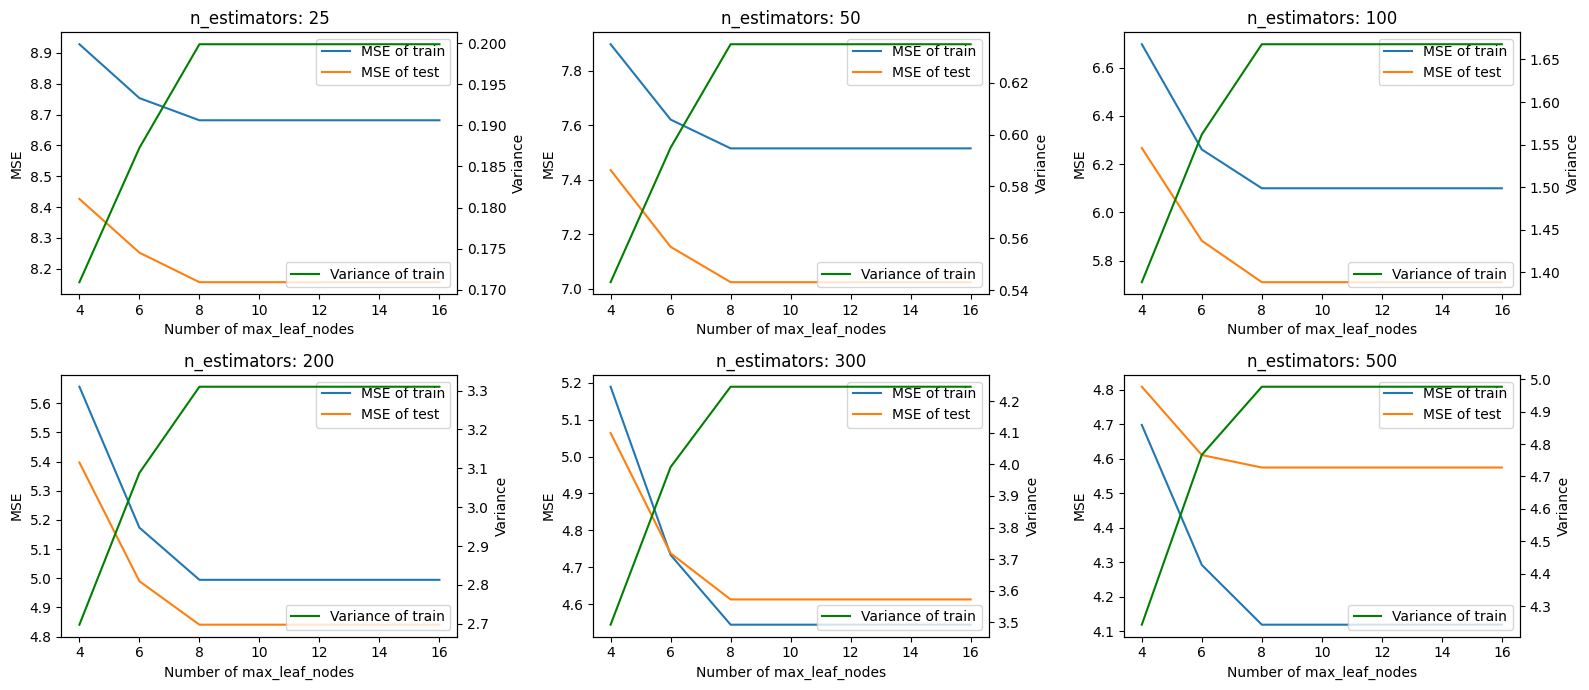

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))
for i, ax in zip(n_estimators_list, axes.ravel()):
    ax.plot(max_leaf_nodes_list, mse_train[i], label='MSE of train')
    ax.plot(max_leaf_nodes_list, mse_test[i], label='MSE of test')
    ax.set_xlabel('Number of max_leaf_nodes')
    ax.set_ylabel('MSE')
    tax = ax.twinx()
    tax.plot(max_leaf_nodes_list, prd_train_var[i], color='green', label='Variance of train')
    tax.set_ylabel('Variance')
    ax.legend()
    tax.legend()
    ax.set_title('n_estimators: {}'.format(i))
plt.tight_layout()
plt.show()

## Voting

여러 종류의 모델을 결합하여, 각각의 모델이 지닌 단점을 서로 보완하여 일반 성능을 향상 시키는 방법입니다.

### Soft Voting vs Hard Voting

분류에서는 개별 모델을 종합하는 방법으로 Soft Voting과 Hard Voting이 있습니다.

- Soft Voting: 개별 모델의 예측확률의 평균이 가장 높은 클래스를 선택합니다.


- Hard Voting: 개별 모델의 예측한 클래스 중 가장 많을 것을 선택합니다.


**sklearn.ensemble.VotingClassifier, VotingRegressor**

**주요 하이퍼파라메터**

|이름|설명|
|---|:-----|
|estimators|(모델명, 모델 인스턴스)로 된 리스트|
|weights|모델별 가중치, None이면 동일 가중치가 적용됩니다.|
|voting|VotingClassifier만 유효합니다. 'soft' or 'hard'|

**[Ex.8]**

<div style="border: 1px solid #ddd; padding: 12px; margin-top: 10px;">

다음 분류 문제를 K최근접 이웃, 로지스틱 회귀, Support Vector Machine, Random Forest, AdaBoost, Gradient Boosting 모델을 만듭니다.

각 모델로 Voting 모델을 만들고 각각의 성능을 비교해봅니다. 

이 때, Soft Voting을 사용합니다.

성능 지표는 AUC(Area Under receiver operating characteristic Curve)입니다. 

모델의 검증 성능 5-Fold 층화 교차 검증을 5 차례 반복하여 결과를 종합하여 검증 성능을 내고, 

평가셋으로 평가 성능을 측정합니다.

df_abalone에서 성별(Sex)가 I이면 -1, M 또는 F이면 1로 하는 변수 Class를 만듭니다.

df_abalone을 80%는 학습데이터 df_train, 20%는 평가데이터 df_test로 나눕니다. 

모델이 추가 될 때마다, 모델의 분산과 df_train, df_test의 성능을 측정해 봅니다. 

성능 측정 지표는 (Area under of receiver charateristic Curve) 입니다.
    
</div>

In [32]:
from sklearn.tree import DecisionTreeClassifier
df_abalone['Class'] = np.where(df_abalone['Sex'] == 'I', -1, 1)

df_train, df_test = train_test_split(df_abalone, train_size=0.8, random_state=123)
X_cols = [i for i in df_train.columns if i != 'Class' and i != 'Sex']
np.array(X_cols)

array(['Length', 'Diameter', 'Height', 'Whole', 'Shucked', 'Viscera',
       'Shell', 'Rings'], dtype='<U8')

In [33]:
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate

# 5-fold Cross Validation을 5번 수행토록 Splitter를 설정합니다.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=123)

def eval_model(name, clf):
    """
    Parameters:
        name: 모델 명칭
        clf: 모델 인스턴스
    Returns:
        Series, 'test'의 roc_auc와 'train'의 roc_auc를 보입니다.
    """
    result = cross_validate(clf, df_train[X_cols], df_train['Class'], cv=cv, scoring='roc_auc', return_train_score=True)
    return pd.Series([
        '{:.3f}±{:.3f}'.format(result['test_score'].mean(), result['test_score'].std()), 
        '{:.3f}±{:.3f}'.format(result['train_score'].mean(), result['train_score'].std())
    ], index=['test', 'train'], name=name)
    
def test_model(clf):
    clf.fit(df_train[X_cols], df_train['Calss'])
    return roc_auc_score(df_test['Class'], clf.predict_proba(df_test[X_cols])[:, 1])


In [34]:
clfs = [
    ('K-Nearest neighbors', make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=50))),
    ('Logistic Regression', make_pipeline(StandardScaler(), LogisticRegression(C=100, solver='lbfgs'))),
    ('Support Vector Machine', make_pipeline(StandardScaler(), SVC(C=10, kernel='poly', degree=2, coef0=1, probability=True))),
    ('Random Forest', RandomForestClassifier(n_estimators=200, max_leaf_nodes=64, random_state=123)),
    ('AdaBoost', AdaBoostClassifier(DecisionTreeClassifier(max_leaf_nodes=4, random_state=123), n_estimators=150, learning_rate=0.05)),
    ('Gradient boosting', GradientBoostingClassifier(n_estimators=150, max_leaf_nodes=4, random_state=123, learning_rate=0.1)),
]

results = [eval_model(i, clf) for i, clf in clfs]

In [35]:
clf_vt = VotingClassifier(clfs, voting='soft')
results.append(eval_model('Voting', clf_vt))

In [36]:
pd.concat(results, axis=1)

,K-Nearest neighbors,Logistic Regression,Support Vector Machine,Random Forest,AdaBoost,Gradient boosting,Voting
test,0.890±0.016,0.886±0.014,0.892±0.014,0.892±0.015,0.882±0.017,0.888±0.016,0.894±0.016
train,0.900±0.004,0.887±0.004,0.897±0.004,0.946±0.003,0.922±0.004,0.928±0.004,0.922±0.003


## 앙상블의 장단점

### 장점

- 여러 모델을 결합시켜 서로 단점을 보완하도록 구성함으로써 보다 성능이 좋을 모델을 만들 수 있습니다.


- 여러 모델의 결합은 출력의 분산을 줄여 주어, 과적합 현상을 완화 시킵니다.


### 단점

- 계산 비용 증가합니다


- 해석이 어려워집니다.


- Boosting은 모델의 결합과 동시에 대상 변수에 적합이 진행되므로, 과적합을 막기 위해서는 정교한 하이퍼 파라메터 최적화가 요구됩니다.